In [1]:
print('Plan -> Do -> Verify')
print('Plan: Configure inputs, harmonize geometries, bin tweets temporally, fuse multi-scale signals, and build rasters.')
print('Do: Each section ingests data, constructs grids, fuses signals, assembles time-aware arrays, and writes exports.')
print('Verify: Assertions validate schemas, CRS alignment, time coverage, and quick-look diagnostics.')


Plan -> Do -> Verify
Plan: Configure inputs, harmonize geometries, bin tweets temporally, fuse multi-scale signals, and build rasters.
Do: Each section ingests data, constructs grids, fuses signals, assembles time-aware arrays, and writes exports.
Verify: Assertions validate schemas, CRS alignment, time coverage, and quick-look diagnostics.


# Tweet Project — Time-Aware Raster Builder

This notebook constructs a fused spatiotemporal raster of tweet intensity by combining evidence from state, county, and city signals.


In [2]:
CONFIG = {
    'event': 'francine',             # Options: 'francine', 'helene'
    'cell_size_km': 25,              # Spatial resolution of output cells (kilometers)
    'time_bin_hours': 6,             # Temporal aggregation window
    'layer_weights': {               # Relative influence of each administrative layer
        'state': 0.5,
        'county': 0.35,
        'city': 0.15
    }
}

MAX_CITY_DISTANCE_KM = 50  # upper bound for associating tweets with a nearby city


In [3]:
import json
import math
from pathlib import Path
from datetime import timedelta

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from shapely.geometry import Point
from shapely.ops import unary_union
from shapely.errors import TopologicalError
from pyproj import CRS
import rasterio
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

np.random.seed(42)

DATA_ROOT = Path('data')
OUTPUT_ROOT = Path('rasters_output') / 'fused_time_intensity'
OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)

EVENT_PATHS = {
    'francine': DATA_ROOT / 'geojson' / 'francine.geojson',
    'helene': DATA_ROOT / 'geojson' / 'helene.geojson'
}

SHAPE_PATHS = {
    'states': DATA_ROOT / 'shape_files' / 'cb_2023_us_state_20m.shp',
    'counties': DATA_ROOT / 'shape_files' / 'cb_2023_us_county_20m.shp'
}

CITIES_PATH = DATA_ROOT / 'tables' / 'cities1000.csv'
TARGET_CRS = CRS.from_epsg(5070)  # NAD83 / Conus Albers — equal-area for conterminous US

assert CONFIG['event'].lower() in EVENT_PATHS, 'Config event must be francine or helene.'
for key, path in {**EVENT_PATHS, **SHAPE_PATHS, 'cities': CITIES_PATH}.items():
    assert Path(path).exists(), f'Missing input: {path}'


## Data ingestion and harmonization


In [4]:
event_key = CONFIG['event'].lower()
raw_tweets = gpd.read_file(EVENT_PATHS[event_key])
states = gpd.read_file(SHAPE_PATHS['states'])
counties = gpd.read_file(SHAPE_PATHS['counties'])
cities = pd.read_csv(CITIES_PATH)

assert {'time', 'geometry'}.issubset(raw_tweets.columns), 'Tweet GeoJSON missing required columns.'
assert 'geometry' in states.columns and 'geometry' in counties.columns, 'Shapefiles lack geometry.'
assert {'latitude', 'longitude', 'country_code', 'geonameid', 'name'}.issubset(cities.columns), 'City table missing expected columns.'

raw_tweets['timestamp'] = pd.to_datetime(raw_tweets['time'], errors='coerce', utc=True)
valid_tweets = raw_tweets.dropna(subset=['timestamp']).copy()
valid_tweets = valid_tweets[~valid_tweets.geometry.is_empty].copy()

if valid_tweets.empty:
    raise ValueError('No tweets with valid timestamps and geometries after preprocessing.')

us_cities = cities.loc[cities['country_code'] == 'US'].copy()
us_cities = us_cities.drop_duplicates(subset=['geonameid'])
city_geometries = gpd.GeoDataFrame(us_cities, geometry=gpd.points_from_xy(us_cities['longitude'], us_cities['latitude']), crs='EPSG:4326')

valid_tweets = valid_tweets.to_crs(TARGET_CRS)
states = states.to_crs(TARGET_CRS)
counties = counties.to_crs(TARGET_CRS)
city_geometries = city_geometries.to_crs(TARGET_CRS)


C:\Users\colto\AppData\Local\Temp\ipykernel_51260\3443105889.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  cities = pd.read_csv(CITIES_PATH)


## Administrative enrichment


In [5]:
tweets = valid_tweets.copy()

state_cols = ['STATEFP', 'NAME', 'GEOID']
county_cols = ['STATEFP', 'COUNTYFP', 'GEOID', 'NAME']

state_join = gpd.sjoin(tweets, states[state_cols + ['geometry']], how='left', predicate='within')
tweets['state_fips'] = state_join['STATEFP'].values
tweets['state_name'] = state_join['NAME'].values
tweets['state_geoid'] = state_join['GEOID'].values

county_join = gpd.sjoin(tweets, counties[county_cols + ['geometry']], how='left', predicate='within')
tweets['county_fips'] = county_join['COUNTYFP'].values
tweets['county_name'] = county_join['NAME'].values
tweets['county_geoid'] = county_join['GEOID'].values

city_join = gpd.sjoin_nearest(
    tweets,
    city_geometries[['geonameid', 'name', 'geometry']],
    how='left',
    distance_col='city_distance_m',
    max_distance=CONFIG['cell_size_km'] * 1000 * 2
)

tweets['city_geonameid'] = city_join['geonameid'].values
tweets['city_name'] = city_join['name'].values
tweets['city_distance_m'] = city_join['city_distance_m'].values

max_city_distance_m = MAX_CITY_DISTANCE_KM * 1000
far_city_mask = tweets['city_distance_m'].notna() & (tweets['city_distance_m'] > max_city_distance_m)
tweets.loc[far_city_mask, ['city_geonameid', 'city_name', 'city_distance_m']] = np.nan

tweets = tweets.sort_values('timestamp').drop_duplicates(subset=['timestamp', 'geometry'])

assert not tweets.empty, 'All tweets dropped during administrative enrichment.'


## Temporal binning and spatial grid


In [6]:
time_bin_hours = CONFIG['time_bin_hours']
cell_size_m = CONFIG['cell_size_km'] * 1000

start_time = tweets['timestamp'].min().floor(f'{time_bin_hours}H')
end_time = tweets['timestamp'].max().ceil(f'{time_bin_hours}H')

if start_time == end_time:
    end_time = end_time + pd.Timedelta(hours=time_bin_hours)

bin_edges = pd.date_range(start=start_time, end=end_time, freq=f'{time_bin_hours}H', tz='UTC')
if len(bin_edges) < 2:
    bin_edges = bin_edges.append(bin_edges[-1:] + pd.Timedelta(hours=time_bin_hours))

relevant_counties = counties[counties.geometry.intersects(tweets.unary_union.buffer(cell_size_m))]
if relevant_counties.empty:
    relevant_counties = counties

processing_extent = unary_union(relevant_counties.geometry).buffer(cell_size_m)

xmin, ymin, xmax, ymax = processing_extent.bounds
width = int(math.ceil((xmax - xmin) / cell_size_m))
height = int(math.ceil((ymax - ymin) / cell_size_m))

xmax = xmin + width * cell_size_m
ymin = ymax - height * cell_size_m
transform = from_origin(xmin, ymax, cell_size_m, cell_size_m)

x_coords = xmin + cell_size_m * (0.5 + np.arange(width))
y_coords = ymax - cell_size_m * (0.5 + np.arange(height))

cell_area_m2 = cell_size_m ** 2

assert width > 0 and height > 0, 'Invalid raster grid dimensions.'


C:\Users\colto\AppData\Local\Temp\ipykernel_51260\1119280617.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time = tweets['timestamp'].min().floor(f'{time_bin_hours}H')
C:\Users\colto\AppData\Local\Temp\ipykernel_51260\1119280617.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end_time = tweets['timestamp'].max().ceil(f'{time_bin_hours}H')
C:\Users\colto\AppData\Local\Temp\ipykernel_51260\1119280617.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bin_edges = pd.date_range(start=start_time, end=end_time, freq=f'{time_bin_hours}H', tz='UTC')
C:\Users\colto\AppData\Local\Temp\ipykernel_51260\1119280617.py:14: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  relevant_counties = counties[counties.geometry.intersects(tweets.unary_union.buffer(cell_size_m))]


## Fusion helpers


In [7]:
def rasterize_polygons(gdf: gpd.GeoDataFrame, value_col: str) -> np.ndarray:
    if gdf.empty:
        return np.zeros((height, width), dtype='float32')
    shapes = ((geom, val) for geom, val in zip(gdf.geometry, gdf[value_col]))
    return features.rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0.0,
        dtype='float32',
        merge_alg=MergeAlg.add
    )


def rasterize_points(gdf: gpd.GeoDataFrame, value_col: str, influence_radius: float) -> np.ndarray:
    if gdf.empty:
        return np.zeros((height, width), dtype='float32')
    buffered = gdf.copy()
    buffered['geometry'] = buffered.geometry.buffer(influence_radius, cap_style=1)
    return rasterize_polygons(buffered, value_col)


def weight_normalizer(weights: dict) -> dict:
    total = sum(weights.values())
    if total == 0:
        raise ValueError('Layer weights cannot all be zero.')
    return {k: v / total for k, v in weights.items()}

layer_weights = weight_normalizer(CONFIG['layer_weights'])


## Time-slice assembly


In [8]:
iterative_arrays = []
cumulative_arrays = []
accumulator = np.zeros((height, width), dtype='float32')

iterative_stats = []
time_labels = []

state_area = states.set_index('GEOID').geometry.area
county_area = counties.set_index('GEOID').geometry.area
city_buffer_radius = cell_size_m / 2

for start, stop in zip(bin_edges[:-1], bin_edges[1:]):
    mask = (tweets['timestamp'] >= start) & (tweets['timestamp'] < stop)
    bin_tweets = tweets.loc[mask]
    time_labels.append(start)
    bin_summary = {
        'start': start.isoformat(),
        'end': stop.isoformat(),
        'tweet_count': int(len(bin_tweets))
    }

    if bin_tweets.empty:
        fused = np.zeros((height, width), dtype='float32')
        iterative_arrays.append(fused)
        accumulator = accumulator + fused
        cumulative_arrays.append(accumulator.copy())
        iterative_stats.append({**bin_summary, 'state_weighted': 0.0, 'county_weighted': 0.0, 'city_weighted': 0.0})
        continue

    state_counts = bin_tweets.groupby('state_geoid').size()
    state_density = state_counts / state_area.reindex(state_counts.index)
    state_layer = states.loc[states['GEOID'].isin(state_counts.index)].copy()
    state_layer['density'] = state_layer['GEOID'].map(state_density.fillna(0))
    state_raster = rasterize_polygons(state_layer, 'density') * cell_area_m2

    county_counts = bin_tweets.groupby('county_geoid').size()
    county_density = county_counts / county_area.reindex(county_counts.index)
    county_layer = counties.loc[counties['GEOID'].isin(county_counts.index)].copy()
    county_layer['density'] = county_layer['GEOID'].map(county_density.fillna(0))
    county_raster = rasterize_polygons(county_layer, 'density') * cell_area_m2

    city_counts = bin_tweets.groupby('city_geonameid').size().dropna()
    if not city_counts.empty:
        city_layer = city_geometries.loc[city_geometries['geonameid'].isin(city_counts.index)].copy()
        city_layer['intensity'] = city_layer['geonameid'].map(city_counts).fillna(0)
        city_raster = rasterize_points(city_layer, 'intensity', city_buffer_radius)
    else:
        city_raster = np.zeros((height, width), dtype='float32')

    fused = (layer_weights['state'] * state_raster +
             layer_weights['county'] * county_raster +
             layer_weights['city'] * city_raster).astype('float32')

    iterative_arrays.append(fused)
    accumulator = accumulator + fused
    cumulative_arrays.append(accumulator.copy())

    iterative_stats.append({**bin_summary,
                           'state_weighted': float(state_raster.sum() * layer_weights['state']),
                           'county_weighted': float(county_raster.sum() * layer_weights['county']),
                           'city_weighted': float(city_raster.sum() * layer_weights['city'])})

assert len(iterative_arrays) == len(bin_edges) - 1, 'Mismatch between bins and raster slices.'


## Build multidimensional rasters


In [9]:
time_index = pd.DatetimeIndex(time_labels).tz_convert('UTC').tz_localize(None)
iterative_stack = np.stack(iterative_arrays)
cumulative_stack = np.stack(cumulative_arrays)

iterative_da = xr.DataArray(
    iterative_stack,
    coords={'time': time_index, 'y': y_coords, 'x': x_coords},
    dims=('time', 'y', 'x'),
    name='tweet_intensity'
)

cumulative_da = xr.DataArray(
    cumulative_stack,
    coords={'time': time_index, 'y': y_coords, 'x': x_coords},
    dims=('time', 'y', 'x'),
    name='tweet_intensity_cumulative'
)

attrs = {
    'description': 'Weighted fusion of state, county, and city tweet signals per time slice.',
    'event': event_key,
    'cell_size_m': cell_size_m,
    'crs_wkt': TARGET_CRS.to_wkt(),
    'weights': json.dumps(layer_weights)
}
iterative_da.attrs.update(attrs)
cumulative_da.attrs.update(attrs)

iterative_da.time.attrs['long_name'] = 'Start of aggregation interval (UTC)'
cumulative_da.time.attrs['long_name'] = 'Start of aggregation interval (UTC)'


## Quick-look diagnostic


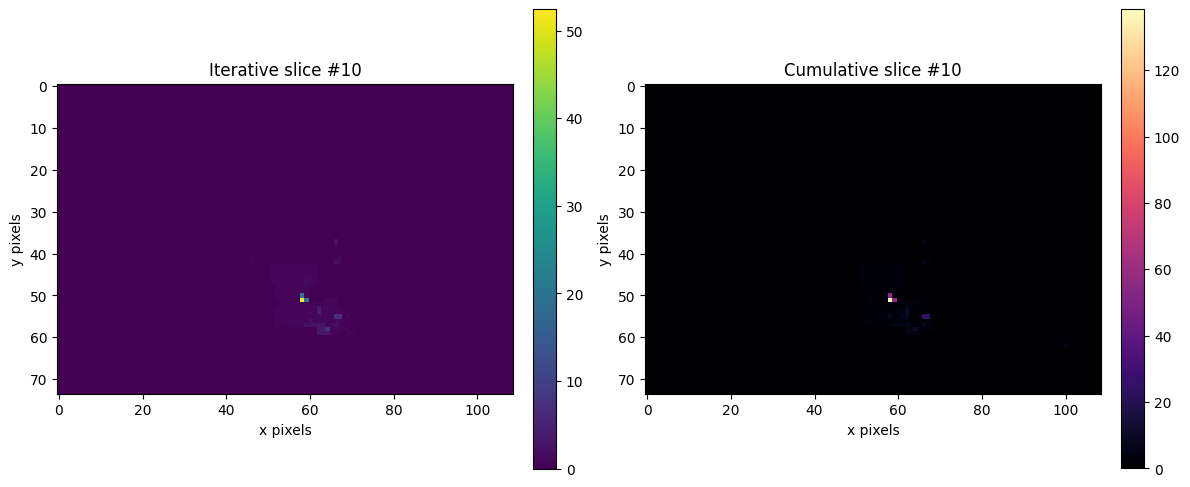

In [10]:
sample_idx = int(np.argmax([arr.sum() for arr in iterative_arrays])) if iterative_arrays else 0
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
if iterative_arrays:
    im = ax[0].imshow(iterative_arrays[sample_idx], origin='upper', cmap='viridis')
    ax[0].set_title(f'Iterative slice #{sample_idx}')
    plt.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)
    im2 = ax[1].imshow(cumulative_arrays[sample_idx], origin='upper', cmap='magma')
    ax[1].set_title(f'Cumulative slice #{sample_idx}')
    plt.colorbar(im2, ax=ax[1], fraction=0.046, pad=0.04)
else:
    ax[0].text(0.5, 0.5, 'No data', ha='center', va='center')
    ax[1].text(0.5, 0.5, 'No data', ha='center', va='center')
for axis in ax:
    axis.set_xlabel('x pixels')
    axis.set_ylabel('y pixels')
plt.tight_layout()
plt.show()


## Export artifacts


In [11]:
base_name = f"{event_key}_{int(CONFIG['cell_size_km'])}km_{int(time_bin_hours)}h"
iterative_path = OUTPUT_ROOT / f"{base_name}_iterative.nc"
cumulative_path = OUTPUT_ROOT / f"{base_name}_cumulative.nc"
per_slice_dir = OUTPUT_ROOT / f"{base_name}_per_slice"
per_slice_dir.mkdir(parents=True, exist_ok=True)

summary_payload = {
    'event': event_key,
    'time_slices': len(iterative_arrays),
    'grid': {'height': height, 'width': width, 'cell_size_m': cell_size_m},
    'weights': layer_weights,
    'time_start': time_index.min().isoformat() if len(time_index) else None,
    'time_end': time_index.max().isoformat() if len(time_index) else None,
    'iterative_path': str(iterative_path),
    'cumulative_path': str(cumulative_path),
    'per_slice_directory': str(per_slice_dir),
    'bin_summaries': iterative_stats
}
print(json.dumps(summary_payload, default=str, separators=(',', ':')))

iterative_da.to_netcdf(iterative_path)
cumulative_da.to_netcdf(cumulative_path)

profile = {
    'driver': 'GTiff',
    'height': height,
    'width': width,
    'count': 1,
    'dtype': 'float32',
    'crs': TARGET_CRS.to_wkt(),
    'transform': transform,
    'compress': 'lzw'
}
for label, arr in zip(time_index, iterative_arrays):
    slice_path = per_slice_dir / f"{base_name}_{label.isoformat().replace(':', '')}.tif"
    with rasterio.open(slice_path, 'w', **profile) as dst:
        dst.write(arr, 1)
        dst.update_tags(start_time=label.isoformat() + 'Z',
                        end_time=(label + pd.Timedelta(hours=time_bin_hours)).isoformat() + 'Z',
                        layer_weights=json.dumps(layer_weights))


{"event":"francine","time_slices":30,"grid":{"height":74,"width":109,"cell_size_m":25000},"weights":{"state":0.5,"county":0.35,"city":0.15},"time_start":"2024-09-09T06:00:00","time_end":"2024-09-16T12:00:00","iterative_path":"rasters_output\\fused_time_intensity\\francine_25km_6h_iterative.nc","cumulative_path":"rasters_output\\fused_time_intensity\\francine_25km_6h_cumulative.nc","per_slice_directory":"rasters_output\\fused_time_intensity\\francine_25km_6h_per_slice","bin_summaries":[{"start":"2024-09-09T06:00:00+00:00","end":"2024-09-09T12:00:00+00:00","tweet_count":3,"state_weighted":1.4846283197402954,"county_weighted":0.8841696977615356,"city_weighted":0.30000001192092896},{"start":"2024-09-09T12:00:00+00:00","end":"2024-09-09T18:00:00+00:00","tweet_count":31,"state_weighted":15.361028671264648,"county_weighted":10.329347610473633,"city_weighted":3.750000238418579},{"start":"2024-09-09T18:00:00+00:00","end":"2024-09-10T00:00:00+00:00","tweet_count":48,"state_weighted":23.691177368

## Quality checks


In [12]:
assert iterative_da.notnull().any(), 'Iterative raster contains only nulls.'
assert cumulative_da.notnull().any(), 'Cumulative raster contains only nulls.'
assert iterative_da.time.size == len(iterative_arrays), 'Mismatch between time coordinate and arrays.'
assert iterative_da.attrs['event'] == event_key, 'Event label mismatch in metadata.'


## README


**Inputs consumed**

- `data/tables/cities1000.csv` (unchanged schema)
- `data/shape_files/cb_2023_us_state_20m.shp`
- `data/shape_files/cb_2023_us_county_20m.shp`
- `data/geojson/{francine|helene}.geojson` based on the configuration

**Fusion logic**

Tweets inherit three spatial signals: (1) state polygons and (2) county polygons identified by containment, and (3) nearest cities within 50 km. For every time bin the notebook converts counts within those units to area-normalized densities, rasterizes each layer at the chosen resolution, buffers city points by half a cell to localize their influence, then combines the layers through the configurable weights. This balances broad coverage with localized emphasis without relying on a pre-existing named recipe.

**Configuration applied in this run**

```json
{"event": "francine", "cell_size_km": 25, "time_bin_hours": 6, "layer_weights": {"state": 0.5, "county": 0.35, "city": 0.15}}
```

**CRS**

All data are projected to EPSG:5070 (NAD83 / Conus Albers) to preserve area when distributing intensity; the CRS choice aligns with the predominantly continental US extent and produces meter-based cell sizes.

**ArcGIS usage**

1. In ArcGIS Pro, add the generated NetCDF (`*_iterative.nc`) as a multidimensional raster layer (Insert → Multidimensional Raster Layer).
2. Ensure the `time` dimension is recognized; ArcGIS automatically reads the `time` coordinate as start times per slice.
3. Optionally load the cumulative NetCDF or per-slice GeoTIFFs for validation.
4. Enable time on the layer to scrub through the fused intensity across intervals.
